# 📍 Extract Points

Herbie's `extract_points` accessor performs a nearest neighbor search to get values from a model grid nearest your points of interest.

For regular latitude-longitude grids, like the GFS and IFS models, this method does the trivial task of doing `xarray.sel` for each of the requested points. However, for curvilinear grids, like the HRRR or RAP models, Herbie uses the BallTree algorithm implemented in **scikit-learn** to find the nearest neighbor indexes.

Note that the BallTree algorithm is implemented instead of the KDTree algorithm because BallTree lets us to use the haversine formula for the minimum distance function, which is important when working with latitude and longitude coordinates.

> Extracting nearest-neighbor points from curvilinear grids has been one of my longstanding questions. In November 2019, I asked [How to select the nearest lat/lon location with multi-dimension coordinates)](https://stackoverflow.com/q/58758480/2383070) on Stack Overflow and I suggested a rudimentary solution. This question is, apparently, one many people have given the 28k views in the last four years.
>
> I iterated over different solutions since then. In the now deprecated Herbie accessor `ds.herbie.nearest_points` used MetPy's [assign_y_x](https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html?highlight=assign_y_x) accessor, transformed the latitude and longitude points to the coordinate reference system coordinates (e.g. lambert conformal for HRRR), and then extracted the nearest neighbor points. That worked fine, but by using the BallTree algorithm now implemented in Herbie's `ds.herbie.extract_points` accessor, we can get the _k_-th nearest neighbors and the distance to the nearest neighbors (haversine formula). I have also implemented the capability to compute the inverse-distance weighted mean of the four (or more) grid points nearest your points of interest.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import warnings

import herbie  # noqa: F401
from herbie import Herbie, FastHerbie

## A Very Simple Demonstration

Let's start with a very simple demonstration to show how extracting nearest points from a grid works.

Let's make a 3x3 xarray Dataset with latitude/longitude coodinates and then extract data nearest two points of interest.

Oh, and you'll need to `import herbie` to use the custom accessor.


In [3]:
# Create a 3x3 xarray dataset
ds = xr.Dataset(
    {"a": (["latitude", "longitude"], [[0, 1, 2], [0, 1, 0], [0, 0, 0]])},
    coords={
        "latitude": (["latitude"], [44, 45, 46]),
        "longitude": (["longitude"], [-99, -100, -101]),
    },
)
ds

<xarray.Dataset> Size: 120B
Dimensions:    (latitude: 3, longitude: 3)
Coordinates:
  * latitude   (latitude) int64 24B 44 45 46
  * longitude  (longitude) int64 24B -99 -100 -101
Data variables:
    a          (latitude, longitude) int64 72B 0 1 2 0 1 0 0 0 0

In [4]:
# We want to extract data closest to two points
points = pd.DataFrame(
    {
        "longitude": [-100.25, -99.4],
        "latitude": [44.25, 45.4],
    }
)
points

,longitude,latitude
0,-100.25,44.25
1,-99.40,45.40


Now we can extract those points with the custom Herbie xarray accessor.

> Note `method='nearest'` is the default behavior.


In [5]:
# Extract the value nearest the requested points
matched = ds.herbie.extract_points(points, method="nearest")
matched

<xarray.Dataset> Size: 96B
Dimensions:          (point: 2)
Coordinates:
    latitude         (point) int64 16B 44 45
    longitude        (point) int64 16B -100 -99
  * point            (point) int64 16B 0 1
    point_longitude  (point) float64 16B -100.2 -99.4
    point_latitude   (point) float64 16B 44.25 45.4
Data variables:
    a                (point) int64 16B 1 0

Alternatively, we can get the inverse-distance weighted mean of the 4 nearest points. This takes 2-4x as long as the simple nearest neighbor, but is still fast.


In [6]:
# Distance weighted mean
matched_w = ds.herbie.extract_points(points, method="weighted")
matched_w

         doesn't know what to name it. Please specify
         `tree_name` to cache the tree for use later.
INFO: 🌱 Growing new BallTree...🌳 BallTree grew in 0.004 seconds.


<xarray.Dataset> Size: 240B
Dimensions:              (point: 2, k: 4)
Coordinates:
    point_longitude      (point) float64 16B -100.2 -99.4
    point_latitude       (point) float64 16B 44.25 45.4
    latitude             (k, point) int64 64B 44 45 44 45 45 46 45 46
    longitude            (k, point) int64 64B -100 -99 -101 ... -99 -101 -100
    point_grid_distance  (k, point) float64 64B 34.22 54.41 66.0 ... 102.4 81.38
Dimensions without coordinates: point, k
Data variables:
    a                    (point) float64 16B 1.082 0.2588

That's a lot of info to digest. I'll plot it for you so you can see what was done...


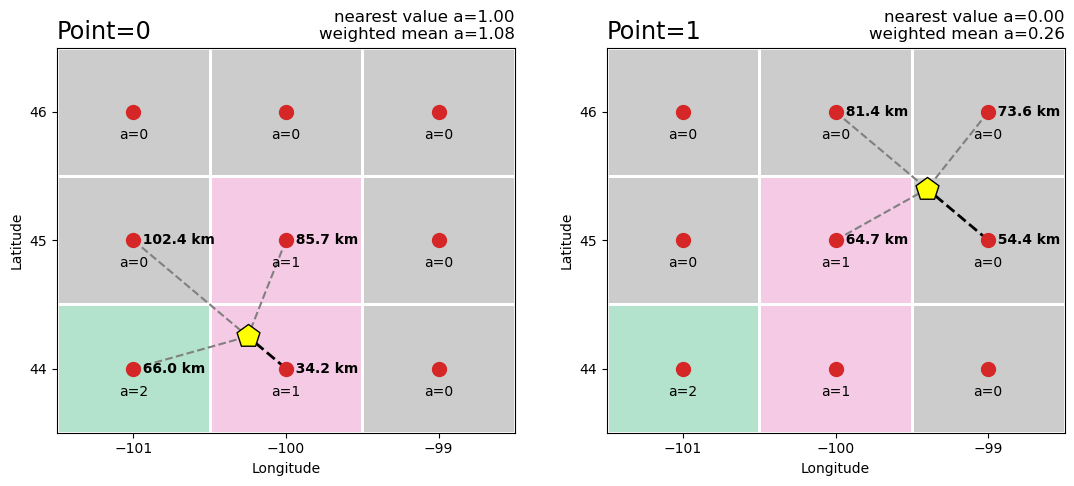

In [7]:
fig, axes = plt.subplots(1, 2, figsize=[13, 5])
for p, ax in zip(matched_w.point, axes):
    zz = matched.sel(point=p)

    # Plot grid
    ax.pcolormesh(
        ds.longitude, ds.latitude, ds.a, edgecolor="1", lw=1, cmap="Pastel2_r"
    )
    x, y = np.meshgrid(ds.longitude, ds.latitude)
    x = x.flatten()
    y = y.flatten()
    ax.scatter(x, y, facecolor="tab:red", edgecolor="tab:red", s=100, zorder=100)

    # Plot requested point
    ax.scatter(
        zz.point_longitude,
        zz.point_latitude,
        color="yellow",
        ec="k",
        marker="p",
        s=300,
        zorder=100,
    )
    for i in ds.latitude:
        for j in ds.longitude:
            z = ds.sel(latitude=i, longitude=j)
            ax.text(j, i, f"\na={z.a.item()}", ha="center", va="top")

    # Plot path to nearest point and distance
    # for i, j in zip(x, y):
    #    ax.plot([i, point.longitude.values[0]], [j, point.latitude.values[0]])
    for i in matched_w.k:
        if i == 0:
            kwargs = dict(lw=2, color="k", ls="--")
        else:
            kwargs = dict(color=".5", ls="--")
        z = matched_w.sel(k=i, point=p)
        ax.plot(
            [z.longitude, z.point_longitude], [z.latitude, z.point_latitude], **kwargs
        )
        ax.text(
            z.longitude,
            z.latitude,
            f"  {z.point_grid_distance.item():.1f} km",
            va="center",
            fontweight="bold",
        )
    ax.set_xticks(ds.longitude)
    ax.set_yticks(ds.latitude)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"Point={p.item()}", loc="left", fontsize="xx-large")
    ax.set_title(
        f"nearest value a={zz.a.item():.2f}\nweighted mean a={z.a.item():.2f}",
        loc="right",
    )

**Summary:** From a simple 2D DataSet with latitude and longitude coordinates, we were able to get the nearest value for two points of interest. We were also able to compute the inverse-distance weighted mean value from the four grids nearest our point of interest.


## Extract points from HRRR data

The above is nice, but you might say, "Yeah, but you can already select data from a grid using [xarray advanced selection](https://docs.xarray.dev/en/stable/user-guide/indexing.html#more-advanced-indexing)." That is true, but it does not work for models with curvilienar grids, like the HRRR model. That is why the BallTree algorithm is needed here to identify the grids nearest a point of interest.

Here is a demonstration using real HRRR data.


In [8]:
H = Herbie("2024-03-01", model="hrrr")
ds = H.xarray(":(?:TMP|DPT):2 m")
ds

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Mar-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


<xarray.Dataset> Size: 46MB
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-01
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (y, x) float64 15MB 21.14 21.15 21.15 ... 47.85 47.84
    longitude            (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.1
    valid_time           datetime64[ns] 8B 2024-03-01
Dimensions without coordinates: y, x
Data variables:
    t2m                  (y, x) float32 8MB 292.5 292.5 292.4 ... 266.8 266.8
    d2m                  (y, x) float32 8MB 287.3 287.2 287.2 ... 262.2 262.2
    gribfile_projection  object 8B None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240301/subset_e0ef89f...
    searchString:            :(?:TMP|DPT):2 m

Let's extract the data from the same two points we used earlier, but this time I will give the two point station id names


In [9]:
points = pd.DataFrame(
    {
        "latitude": [44.25, 45.4],
        "longitude": [-100.25, -99.4],
        "stid": ["apple", "orange"],
    }
)
points

,latitude,longitude,stid
0,44.25,-100.25,apple
1,45.40,-99.40,orange


In [10]:
%%time
matched = ds.herbie.extract_points(points)
matched

CPU times: user 138 ms, sys: 267 ms, total: 405 ms
Wall time: 452 ms


<xarray.Dataset> Size: 144B
Dimensions:              (point: 2)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-01
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (point) float64 16B 44.26 45.4
    longitude            (point) float64 16B 259.8 260.6
    valid_time           datetime64[ns] 8B 2024-03-01
    point_grid_distance  (point) float64 16B 1.103 1.054
    point_latitude       (point) float64 16B 44.25 45.4
    point_longitude      (point) float64 16B -100.2 -99.4
    point_stid           (point) object 16B 'apple' 'orange'
Dimensions without coordinates: point
Data variables:
    t2m                  (point) float32 8B 288.0 283.6
    d2m                  (point) float32 8B 269.4 271.4
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240301/subset_e0ef89f...
    searchString:            :(?:TMP|DPT):2 m

Notice that the BallTree object was saved with the name `<model_name>_<x_dim>_<y_dim>.pkl` so it can be loaded more quickly next time you extract points from this grid. In the next cell I run the same command, and it uses the cached tree instead.


In [11]:
%%time
matched = ds.herbie.extract_points(points)
matched

CPU times: user 141 ms, sys: 91.2 ms, total: 233 ms
Wall time: 264 ms


<xarray.Dataset> Size: 144B
Dimensions:              (point: 2)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-01
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (point) float64 16B 44.26 45.4
    longitude            (point) float64 16B 259.8 260.6
    valid_time           datetime64[ns] 8B 2024-03-01
    point_grid_distance  (point) float64 16B 1.103 1.054
    point_latitude       (point) float64 16B 44.25 45.4
    point_longitude      (point) float64 16B -100.2 -99.4
    point_stid           (point) object 16B 'apple' 'orange'
Dimensions without coordinates: point
Data variables:
    t2m                  (point) float32 8B 288.0 283.6
    d2m                  (point) float32 8B 269.4 271.4
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240301/subset_e0ef89f...
    searchString:            :(?:TMP|DPT):2 m

You may swap the dimesions to use the `point_stid` coordinate as the dimension. This makes it possible to select data by station ID instead of point index.


In [12]:
matched = matched.swap_dims({"point": "point_stid"})
matched.sel(point_stid="apple")

<xarray.Dataset> Size: 100B
Dimensions:              ()
Coordinates:
    time                 datetime64[ns] 8B 2024-03-01
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             float64 8B 44.26
    longitude            float64 8B 259.8
    valid_time           datetime64[ns] 8B 2024-03-01
    point_grid_distance  float64 8B 1.103
    point_latitude       float64 8B 44.25
    point_longitude      float64 8B -100.2
    point_stid           <U5 20B 'apple'
Data variables:
    t2m                  float32 4B 288.0
    d2m                  float32 4B 269.4
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240301/subset_e0ef89f...
    searchString:            :(?:TMP|DPT):2 m

Now plot each point on a map with the value at the nearest grid point.


<GeoAxes: >

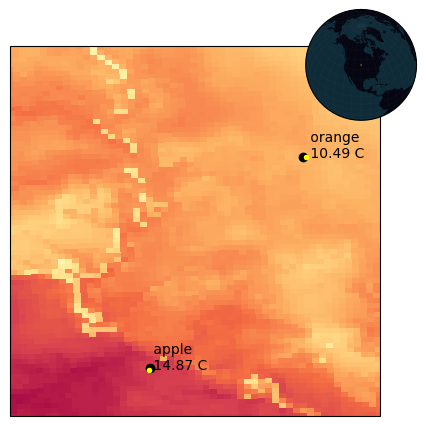

In [13]:
from toolbox import EasyMap, pc, ccrs

ax = EasyMap().ax
ax.pcolormesh(ds.longitude, ds.latitude, ds.t2m, cmap="Spectral_r", vmax=290, vmin=270)

for i in matched.point_stid:
    z = matched.sel(point_stid=i)
    ax.scatter(z.longitude, z.latitude, color="k")
    ax.scatter(z.point_longitude, z.point_latitude, color="yellow", marker=".")
    ax.text(
        z.point_longitude,
        z.point_latitude,
        f" {z.point_stid.item()}\n {z.t2m.item()-273.15:.2f} C",
    )
ax.set_extent([-101, -99, 44, 46])
ax.EasyMap.INSET_GLOBE()

## Extract Point Sounding

If you want a "sounding" at a single point, you will need to get the GRIB data for all the model layers of interest (yes, that's a lot of data), then extract the point.


In [14]:
# TODO: Get some real sounding data using SounderPy and plot against model data

In [15]:
H = Herbie("2024-03-28 00:00", model="hrrr", product="prs")
ds = H.xarray("(?:DPT|TMP):[0-9]* mb", remove_grib=False)

# Get HRRR sounding at Salt Lake City
slc = ds.herbie.extract_points(
    pd.DataFrame({"latitude": [40.76], "longitude": [-111.876183]})
)
slc

✅ Found ┊ model=hrrr ┊ product=prs ┊ 2024-Mar-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


<xarray.Dataset> Size: 688B
Dimensions:              (isobaricInhPa: 39, point: 1)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-28
    step                 timedelta64[ns] 8B 00:00:00
  * isobaricInhPa        (isobaricInhPa) float64 312B 1e+03 975.0 ... 75.0 50.0
    latitude             (point) float64 8B 40.75
    longitude            (point) float64 8B 248.1
    valid_time           datetime64[ns] 8B 2024-03-28
    point_grid_distance  (point) float64 8B 1.193
    point_latitude       (point) float64 8B 40.76
    point_longitude      (point) float64 8B -111.9
Dimensions without coordinates: point
Data variables:
    t                    (isobaricInhPa, point) float32 156B ...
    dpt                  (isobaricInhPa, point) float32 156B ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 prs
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240328/subset_0befd2f...
    searchString:            (?:DPT|TMP):[0-9]* mb

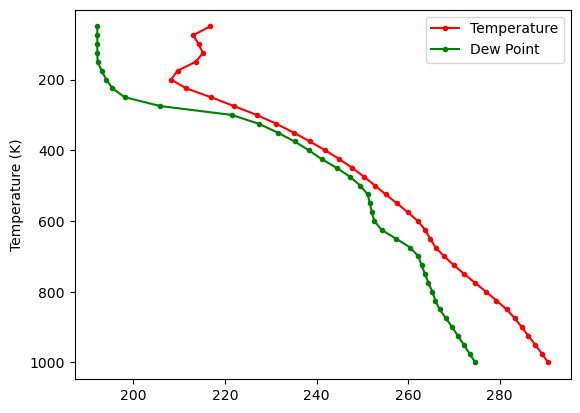

In [16]:
# TODO: plot data on a sounding plot using MetPy

ax = plt.gca()
ax.plot(slc.t, slc.isobaricInhPa, color="red", marker=".", label="Temperature")
ax.plot(slc.dpt, slc.isobaricInhPa, color="green", marker=".", label="Dew Point")
ax.invert_yaxis()
ax.set_ylabel("Level (hPa)")
ax.set_ylabel("Temperature (K)")
ax.legend()

## Extract Point Timeseries


✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 03:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 06:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 09:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 15:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 18:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 21:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


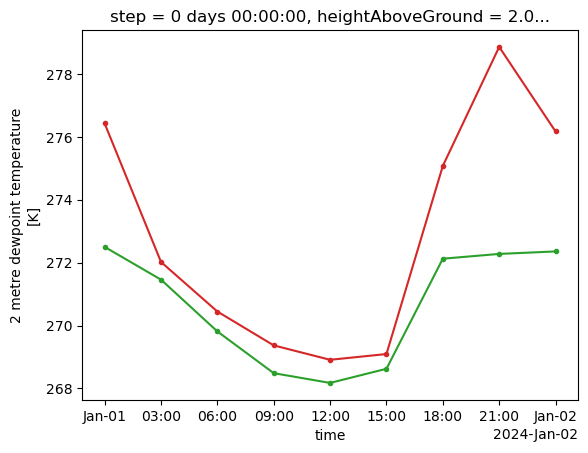

In [17]:
# TODO: Could demonstrate using FastHerbie here, if the kernel wouldn't crash (memory??)

i = []
for date in pd.date_range("2024-01-01", periods=9, freq="3h"):
    ds = Herbie(date).xarray("(?:DPT|TMP):2 m")
    i.append(
        ds.herbie.extract_points(
            pd.DataFrame(
                {
                    "latitude": [40.77069],
                    "longitude": [-111.96503],
                    "stid": ["KSLC"],
                }
            )
        )
    )
slc_ts = xr.concat(i, dim="valid_time")

slc_ts.t2m.plot(x="valid_time", marker=".", color="tab:red")
slc_ts.d2m.plot(x="valid_time", marker=".", color="tab:green")

## Benchmark

Let's see how fast `ds.herbie.extract_points` runs for many points...


In [18]:
H = Herbie("2024-03-28 00:00", model="hrrr")
ds = H.xarray(r"TMP:\d* mb", remove_grib=False)
ds

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Mar-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


<xarray.Dataset> Size: 69MB
Dimensions:              (isobaricInhPa: 5, y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-28
    step                 timedelta64[ns] 8B 00:00:00
  * isobaricInhPa        (isobaricInhPa) float64 40B 1e+03 925.0 ... 700.0 500.0
    latitude             (y, x) float64 15MB ...
    longitude            (y, x) float64 15MB ...
    valid_time           datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Data variables:
    t                    (isobaricInhPa, y, x) float32 38MB ...
    gribfile_projection  object 8B None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240328/subset_0befe27...
    searchString:            TMP:\d* mb

Using the model's own grid, I will generate 100 random samples to extract.


In [19]:
def generate_random_string(len=8):
    """Generate a random string."""
    import random
    import string

    return "".join(random.choices(string.ascii_letters + string.digits, k=len))


n = 100
points_self = (
    ds[["latitude", "longitude"]]
    .to_dataframe()[["latitude", "longitude"]]
    .sample(n)
    .reset_index(drop=True)
)
points_self["stid"] = [generate_random_string() for _ in range(n)]
points_self

,latitude,longitude,stid
0,29.522393,290.403179,ciTxApbH
1,34.523529,291.044107,GL9G0XYO
2,42.362760,289.584455,Qi0tl8lG
3,41.716044,277.901543,GPsZArYR
4,23.202427,245.456864,Za9yejgP
...,...,...,...
95,33.800765,289.918171,DOFsraHn
96,37.412972,270.484783,eOuP1y3f
97,49.337037,236.516181,TlBAeAUd
98,45.458129,242.566243,PH98owaH


In [20]:
%%timeit
y1 = ds.herbie.extract_points(points_self)

102 ms ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%%timeit
y2 = ds.herbie.extract_points(points_self, method="weighted")

1.24 s ± 344 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
# Try the deprecated `nearest_points` method which used MetPy
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    y3 = ds.herbie.nearest_points(points_self)

373 ms ± 45.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
# Do I get the same answer for the old and new method?
y1 = ds.herbie.extract_points(points_self)
y2 = ds.herbie.extract_points(points_self, method="weighted")
y3 = ds.herbie.nearest_points(points_self)

all(y1.latitude == y3.latitude), all(y1.longitude == y3.longitude)

/tmp/ipykernel_17497/3104235764.py:4: DeprecationWarning: The accessor `ds.herbie.nearest_points` is deprecated in favor of the `ds.herbie.extract_points` which uses the BallTree algorithm instead.
  y3 = ds.herbie.nearest_points(points_self)
/home/blaylock/GITHUB/Herbie/herbie/accessors.py:541: UserWarning: More than one time coordinate present for variable  "gribfile_projection".
  ds = ds.metpy.parse_cf()
/home/blaylock/GITHUB/Herbie/herbie/accessors.py:545: UserWarning: More than one time coordinate present for variable  "t".
  ds = ds.metpy.assign_y_x()
/home/blaylock/GITHUB/Herbie/herbie/accessors.py:545: UserWarning: More than one time coordinate present for variable  "gribfile_projection".
  ds = ds.metpy.assign_y_x()


(True, True)

<GeoAxes: >

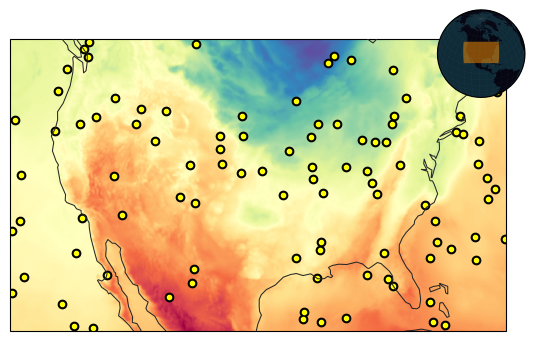

In [24]:
ax = EasyMap(crs=ds.herbie.crs).ax

ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.isel(isobaricInhPa=0).t,
    cmap="Spectral_r",
    transform=pc,
)

ax.scatter(y1.longitude, y1.latitude, color="k", transform=pc)
ax.scatter(
    y1.point_longitude, y1.point_latitude, color="yellow", marker=".", transform=pc
)

ax.EasyMap.INSET_GLOBE()

Not bad. Less than half a second to extract 100 points from the HRRR grid.

Now let's try _even more_...


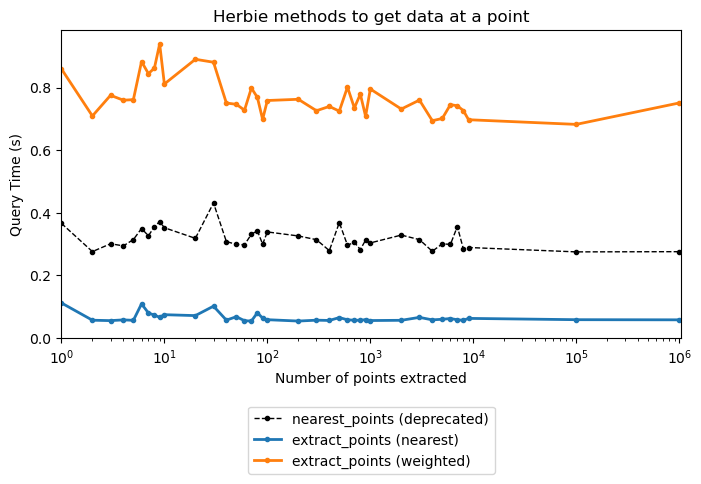

In [25]:
n_samples = (
    [1, 2, 3, 4, 5, 6, 7, 8, 9]
    + list(range(10, 100, 10))
    + list(range(100, 1_000, 100))
    + list(range(1_000, 10_000, 1_000))
    + [100_000, 1_000_000]
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Timers for nearest_points (deprecated)
    times_np = []
    samples_np = []

    # Timers for extract_points method='nearest'
    times_ep = []
    samples_ep = []

    # Timers for extract_points method='weighted'
    times_w = []
    samples_w = []

    for s in n_samples:
        samples_np.append(s)
        timer = pd.Timestamp("now")
        y1 = ds.herbie.nearest_points(points_self)
        times_np.append((pd.Timestamp("now") - timer).total_seconds())

        samples_ep.append(s)
        timer = pd.Timestamp("now")
        y1 = ds.herbie.extract_points(points_self, method="nearest")
        times_ep.append((pd.Timestamp("now") - timer).total_seconds())

        samples_w.append(s)
        timer = pd.Timestamp("now")
        y1 = ds.herbie.extract_points(points_self, method="weighted")
        times_w.append((pd.Timestamp("now") - timer).total_seconds())


plt.figure(figsize=[8, 4])
plt.plot(
    samples_np,
    times_np,
    marker=".",
    lw=1,
    color="k",
    ls="--",
    label="nearest_points (deprecated)",
)
plt.plot(
    samples_ep,
    times_ep,
    marker=".",
    lw=2,
    color="tab:blue",
    label="extract_points (nearest)",
)
plt.plot(
    samples_w,
    times_w,
    marker=".",
    lw=2,
    color="tab:orange",
    label="extract_points (weighted)",
)
plt.title("Herbie methods to get data at a point")
plt.xlabel("Number of points extracted")
plt.ylabel("Query Time (s)")
plt.ylim(ymin=0)
plt.xlim(xmin=1)
plt.legend(loc="upper center", bbox_to_anchor=[0.5, -0.2])
plt.gca().set_xscale("log")

Nice! This method scales well for extracting many points. If you want to extract many points, you don't get penalized 😎


For models that have regular latitude-longitude coordinates (e.g., GFS, IFS), the selection of points is trivial with `xarray.sel`. Herbie uses this trivial solution if it is possible by default. But you can still use the BallTree algorithm instead if you want to get the distance calculation between grid and point location.


In [26]:
gfs = Herbie("2024-01-01", model="gfs").xarray(":TMP:2 m ")

✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2024-Jan-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


In [27]:
%%time
gfs.herbie.extract_points(points_self)

# notice how fast this ran, but there is no `point_grid_distance`

CPU times: user 22.1 ms, sys: 1.62 ms, total: 23.8 ms
Wall time: 19.5 ms


<xarray.Dataset> Size: 5kB
Dimensions:              (point: 100)
Coordinates:
    time                 datetime64[ns] 8B 2024-01-01
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (point) float64 800B 29.5 34.5 42.25 ... 45.5 50.0
    longitude            (point) float64 800B 290.5 291.0 289.5 ... 242.5 273.0
    valid_time           datetime64[ns] 8B 2024-01-01
  * point                (point) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    point_latitude       (point) float64 800B 29.52 34.52 42.36 ... 45.46 49.92
    point_longitude      (point) float64 800B 290.4 291.0 289.6 ... 242.6 273.0
    point_stid           (point) object 800B 'ciTxApbH' ... 'Bi7zEFpu'
Data variables:
    t2m                  (point) float32 400B 293.3 289.2 276.8 ... 276.1 260.2
    gribfile_projection  object 8B None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   gfs
    product:                 pgrb2.0p25
    description:             Global Forecast System
    remote_grib:             https://noaa-gfs-bdp-pds.s3.amazonaws.com/gfs.20...
    local_grib:              /home/blaylock/data/gfs/20240101/subset_6bef22b0...
    searchString:            :TMP:2 m

In [29]:
%%time
gfs.herbie.extract_points(points_self, k=1)

# This took a little longer because we used BallTree to get the
# nearest point, but now we have the `point_grid_distance` coordinate.

CPU times: user 48.8 ms, sys: 9.86 ms, total: 58.6 ms
Wall time: 56.2 ms


<xarray.Dataset> Size: 5kB
Dimensions:              (point: 100)
Coordinates:
    time                 datetime64[ns] 8B 2024-01-01
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (point) float64 800B 29.5 34.5 42.25 ... 45.5 50.0
    longitude            (point) float64 800B 290.5 291.0 289.5 ... 242.5 273.0
    valid_time           datetime64[ns] 8B 2024-01-01
    point_grid_distance  (point) float64 800B 9.694 4.814 14.33 ... 6.954 8.692
    point_latitude       (point) float64 800B 29.52 34.52 42.36 ... 45.46 49.92
    point_longitude      (point) float64 800B 290.4 291.0 289.6 ... 242.6 273.0
    point_stid           (point) object 800B 'ciTxApbH' ... 'Bi7zEFpu'
Dimensions without coordinates: point
Data variables:
    t2m                  (point) float32 400B 293.3 289.2 276.8 ... 276.1 260.2
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   gfs
    product:                 pgrb2.0p25
    description:             Global Forecast System
    remote_grib:             https://noaa-gfs-bdp-pds.s3.amazonaws.com/gfs.20...
    local_grib:              /home/blaylock/data/gfs/20240101/subset_6bef22b0...
    searchString:            :TMP:2 m

## Advanced Options

The default behavior for `method='nearest'` is to return the first nearest neighbor. The default behavior for `method='weighted'` is to return the inverse-distance weighted mean of the nearest 4 grid points.

You can get more or fewer neighbors by setting the `k` argument. This might be useful if you want to compute the standard deviation of the _k_ grid points surrounding a point of interest.


In [30]:
%%time
# Return the 5 nearest grid points to each request point
ds.herbie.extract_points(points_self, method="nearest", k=5)

CPU times: user 1.1 s, sys: 118 ms, total: 1.22 s
Wall time: 1.22 s


<xarray.Dataset> Size: 24kB
Dimensions:              (k: 5, isobaricInhPa: 5, point: 100)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-28
    step                 timedelta64[ns] 8B 00:00:00
  * isobaricInhPa        (isobaricInhPa) float64 40B 1e+03 925.0 ... 700.0 500.0
    latitude             (k, point) float64 4kB 29.52 34.52 42.36 ... 45.43 49.9
    longitude            (k, point) float64 4kB 290.4 291.0 ... 242.6 273.0
    valid_time           datetime64[ns] 8B 2024-03-28
    point_grid_distance  (k, point) float64 4kB 0.0 0.0 0.0 ... 2.977 2.937
    point_latitude       (point) float64 800B 29.52 34.52 42.36 ... 45.46 49.92
    point_longitude      (point) float64 800B 290.4 291.0 289.6 ... 242.6 273.0
    point_stid           (point) object 800B 'ciTxApbH' ... 'Bi7zEFpu'
Dimensions without coordinates: k, point
Data variables:
    t                    (k, isobaricInhPa, point) float32 10kB 292.8 ... 246.5
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240328/subset_0befe27...
    searchString:            TMP:\d* mb

In [31]:
%%time
# Compute the distance weighted mean for the 9 nearest grid points to
# each request point
ds.herbie.extract_points(points_self, method="weighted", k=9)

CPU times: user 1.76 s, sys: 68.7 ms, total: 1.83 s
Wall time: 1.82 s


<xarray.Dataset> Size: 28kB
Dimensions:              (isobaricInhPa: 5, point: 100, k: 9)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-28
    step                 timedelta64[ns] 8B 00:00:00
  * isobaricInhPa        (isobaricInhPa) float64 40B 1e+03 925.0 ... 700.0 500.0
    valid_time           datetime64[ns] 8B 2024-03-28
    point_latitude       (point) float64 800B 29.52 34.52 42.36 ... 45.46 49.92
    point_longitude      (point) float64 800B 290.4 291.0 289.6 ... 242.6 273.0
    point_stid           (point) object 800B 'ciTxApbH' ... 'Bi7zEFpu'
    latitude             (k, point) float64 7kB 29.52 34.52 ... 45.43 49.89
    longitude            (k, point) float64 7kB 290.4 291.0 ... 242.5 273.0
    point_grid_distance  (k, point) float64 7kB 0.0 0.0 0.0 ... 4.163 4.21 4.154
Dimensions without coordinates: point, k
Data variables:
    t                    (isobaricInhPa, point) float64 4kB 292.8 ... 246.5

Suppose I wanted to get the standard deviation of model surface height around each of my points.


In [52]:
ds = Herbie("2024-01-01").xarray("HGT:surface")
dsp = ds.herbie.extract_points(points_self, k=100)
dsp

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


<xarray.Dataset> Size: 282kB
Dimensions:              (k: 100, point: 100)
Coordinates:
    time                 datetime64[ns] 8B 2024-01-01
    step                 timedelta64[ns] 8B 00:00:00
    surface              float64 8B 0.0
    latitude             (k, point) float64 80kB 29.52 34.52 ... 45.38 49.83
    longitude            (k, point) float64 80kB 290.4 291.0 ... 242.7 272.8
    valid_time           datetime64[ns] 8B 2024-01-01
    point_grid_distance  (k, point) float64 80kB 0.0 0.0 0.0 ... 16.84 16.62
    point_latitude       (point) float64 800B 29.52 34.52 42.36 ... 45.46 49.92
    point_longitude      (point) float64 800B 290.4 291.0 289.6 ... 242.6 273.0
    point_stid           (point) object 800B 'ciTxApbH' ... 'Bi7zEFpu'
Dimensions without coordinates: k, point
Data variables:
    orog                 (k, point) float32 40kB -0.01786 0.01339 ... 380.8
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240101/subset_6bef832...
    searchString:            HGT:surface

In [67]:
z = dsp.orog.std(dim="k")
z

<xarray.DataArray 'orog' (point: 100)> Size: 400B
array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.15527344e-05,
       1.05094826e-02, 1.40138054e-02, 2.33970322e+02, 0.00000000e+00,
       9.32900047e+00, 2.34989529e+01, 0.00000000e+00, 2.27547741e+01,
       3.05282688e+01, 8.92403946e+01, 1.94554348e+01, 0.00000000e+00,
       0.00000000e+00, 9.94913406e+01, 0.00000000e+00, 1.54965849e+01,
       1.00481018e+02, 3.79540977e+01, 0.00000000e+00, 2.77610291e+02,
       6.80163383e+00, 0.00000000e+00, 0.00000000e+00, 6.43548737e+01,
       0.00000000e+00, 1.80008408e+02, 0.00000000e+00, 1.77675457e+01,
       1.29343729e+01, 0.00000000e+00, 0.00000000e+00, 9.41577435e+00,
       1.31999008e+02, 5.97885666e+01, 1.13107252e+01, 0.00000000e+00,
       2.46522427e+01, 1.32691788e+02, 1.08433440e-02, 1.96814480e+01,
       0.00000000e+00, 2.56658707e+01, 4.52559620e-01, 2.20788223e+02,
       2.14183998e+01, 1.96495972e+02, 2.62361622e+01, 0.00000000e+00,
       2.72304821e+01, 1.80477393e+00, 0.00000000e+00, 1.42568985e+02,
       6.13264923e+01, 1.47778921e+01, 8.43123932e+01, 1.18126936e+01,
       1.78852493e+02, 0.00000000e+00, 0.00000000e+00, 1.81061897e+01,
       6.57736212e-02, 0.00000000e+00, 9.15527344e-05, 6.98476715e+01,
       5.33433838e+01, 1.44049635e+01, 0.00000000e+00, 7.82032061e+00,
       0.00000000e+00, 0.00000000e+00, 1.69345741e+01, 0.00000000e+00,
       3.12945190e+02, 4.26725998e+01, 1.01118515e+02, 4.96377754e+01,
       0.00000000e+00, 1.06570305e+02, 1.68264427e+01, 5.99717283e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.54495468e+01, 2.50479584e+01, 0.00000000e+00, 6.81078015e-03,
       1.36970806e+01, 1.59705688e+02, 2.05886555e+01, 0.00000000e+00,
       2.80344028e+01, 1.64455185e+02, 3.73949646e+02, 1.90995293e+01],
      dtype=float32)
Coordinates:
    time             datetime64[ns] 8B 2024-01-01
    step             timedelta64[ns] 8B 00:00:00
    surface          float64 8B 0.0
    valid_time       datetime64[ns] 8B 2024-01-01
    point_latitude   (point) float64 800B 29.52 34.52 42.36 ... 45.46 49.92
    point_longitude  (point) float64 800B 290.4 291.0 289.6 ... 242.6 273.0
    point_stid       (point) object 800B 'ciTxApbH' 'GL9G0XYO' ... 'Bi7zEFpu'
Dimensions without coordinates: point

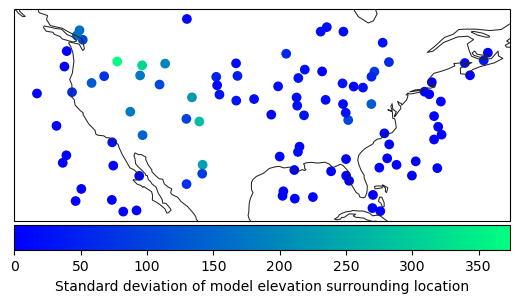

In [66]:
ax = EasyMap().ax
art = ax.scatter(z.point_longitude, z.point_latitude, c=z, cmap="winter")
plt.colorbar(
    art,
    ax=ax,
    label="Standard deviation of model elevation surrounding location",
    orientation="horizontal",
    pad=0.01,
)